# 04 - Modeling: next episode continuation (anime_simulated)

This notebook:

- Loads the ML dataset (`ml_dataset.parquet`)
- Loads the trained model (`next_episode_model.pkl`)
- Recomputes validation metrics for sanity
- Plots:
  - ROC curve
  - Precision and recall across thresholds
- Looks at feature importance (using permutation importance)
- Explores performance by episode number

In [1]:
from pathlib import Path
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.inspection import permutation_importance

In [2]:
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parents[1]

In [3]:
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

In [4]:
from anime_simulated.src.config import PROCESSED_DIR, ML_DATASET_FILE, MODELS_DIR, MODEL_FILE, RNG_SEED

In [5]:
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 140)

In [6]:
ml_path = PROCESSED_DIR / ML_DATASET_FILE
model_path = MODELS_DIR / MODEL_FILE
print(ml_path)
print(model_path)

/Users/sanjaydilip/Desktop/Code/Projects/sim2real user engagement/anime_simulated/data/processed/ml_dataset.parquet
/Users/sanjaydilip/Desktop/Code/Projects/sim2real user engagement/anime_simulated/models/next_episode_model.pkl


In [7]:
ml_df = pd.read_parquet(ml_path)
ml_df.head()

,user_id,anime_row_id,anime_title,watch_start_time,label_next_episode,episode_number,watch_time_sec,completed_fraction,engagement_level,anime_num_watch_events,anime_num_users,anime_mean_p_continue,user_prev_episodes,user_prev_episodes_this_anime,user_prev_cont_rate
0,1,19600,Magnerobo Ga-Keen,2024-01-01 00:00:00.000000,1,1,971,0.809331,0.424548,3,1,0.679949,0,0,0.706940
1,1,19600,Magnerobo Ga-Keen,2024-01-02 19:40:27.893000,1,2,894,0.745706,0.424548,3,1,0.679949,1,1,1.000000
2,1,19600,Magnerobo Ga-Keen,2024-01-03 01:10:25.891134,0,3,961,0.800906,0.424548,3,1,0.679949,2,2,1.000000
3,1,9258,Fushigiboshi no☆Futagohime,2024-01-11 00:00:00.000000,1,1,1200,1.000000,0.424548,5,2,0.699511,3,0,0.666667
4,1,9258,Fushigiboshi no☆Futagohime,2024-01-12 05:33:18.614273,1,2,873,0.728261,0.424548,5,2,0.699511,4,1,0.750000


In [8]:
with open(model_path, "rb") as f:
    payload = pickle.load(f)

In [9]:
model = payload["model"]
feature_cols = payload["feature_cols"]
feature_cols

['episode_number',
 'watch_time_sec',
 'completed_fraction',
 'engagement_level',
 'anime_num_watch_events',
 'anime_num_users',
 'anime_mean_p_continue',
 'user_prev_episodes',
 'user_prev_episodes_this_anime',
 'user_prev_cont_rate']

## Rebuild X, y and a simple train / validation split

We will mirror the logic used in `models.py`:

- Same feature columns
- Same target (`label_next_episode`)
- Same random split 

in order to reproduce metrics and plots

In [10]:
from sklearn.model_selection import train_test_split
target_col = "label_next_episode"
X = ml_df[feature_cols].to_numpy(dtype=float)
y = ml_df[target_col].to_numpy(dtype=int)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RNG_SEED,
    stratify=y,
)
print("Shape of X:", X.shape)
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)

Shape of X: (50703, 10)
Shape of X_train: (40562, 10)
Shape of X_val: (10141, 10)


## Basic metrics and confusion matrix

We compute:

- Accuracy
- Precision
- Recall
- F1
- ROC AUC

Then we show the confusion matrix at the default 0.5 threshold.

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_pred = model.predict(X_val)

In [13]:
if hasattr(model, "predict_proba"):
    y_proba = model.predict_proba(X_val)[:, 1]
elif hasattr(model, "decision_function"):
    scores = model.decision_function(X_val)
    y_proba = 1.0 / (1.0 + np.exp(-scores))
else:
    y_proba = y_pred.astype(float)

In [14]:
metrics = {
    "accuracy": accuracy_score(y_val, y_pred),
    "precision": precision_score(y_val, y_pred, zero_division=0),
    "recall": recall_score(y_val, y_pred, zero_division=0),
    "f1": f1_score(y_val, y_pred, zero_division=0),
    "roc_auc": roc_auc_score(y_val, y_proba),
}
metrics

{'accuracy': 0.8164875258850212,
 'precision': 0.8164798473646554,
 'recall': 0.9550843911284698,
 'f1': 0.880360012857602,
 'roc_auc': np.float64(0.859116458123966)}

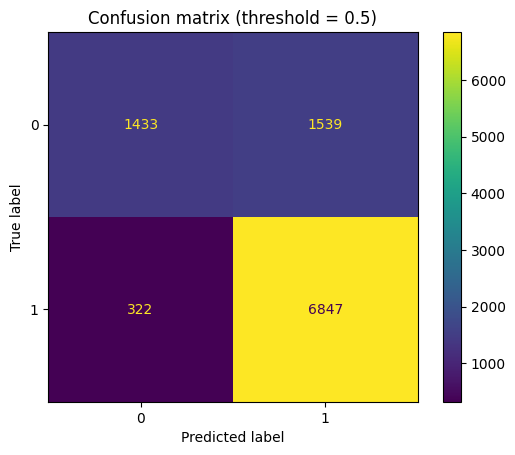

In [15]:
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion matrix (threshold = 0.5)")
plt.show()

## ROC curve

A quick ROC curve helps visualise the tradeoff across thresholds.

In [16]:
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
roc_auc = roc_auc_score(y_val, y_proba)

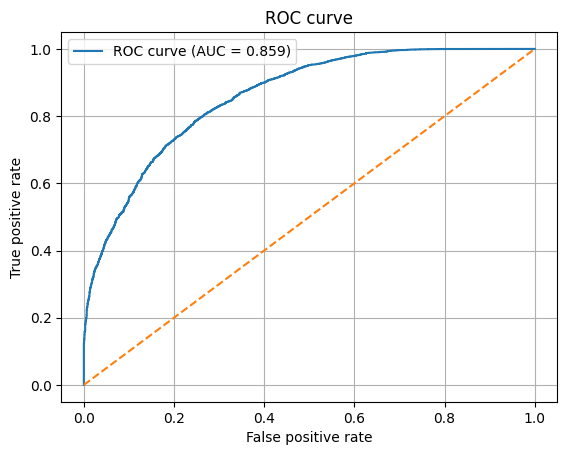

In [17]:
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:0.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.legend()
plt.grid(True)
plt.show()

## Precision and recall across thresholds

Instead of a single 0.5 cut, it is useful to see how precision and recall move as we slide the threshold.

This is important for engagement use cases:

- Very high recall might be needed if you want to catch almost everyone who will continue.
- Higher precision might be needed if interventions are expensive.

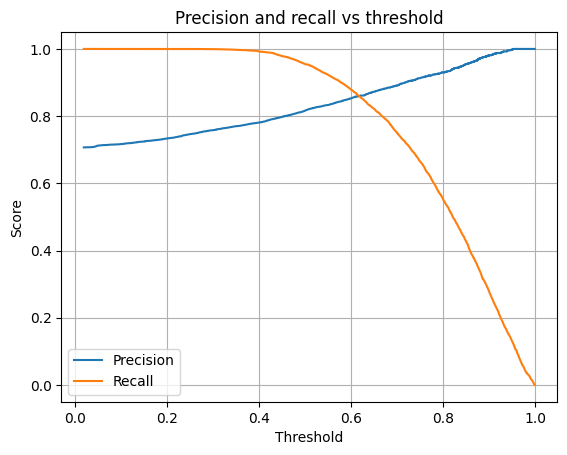

In [18]:
precisions, recalls, pr_thresholds = precision_recall_curve(y_val, y_proba)
plt.figure()
plt.plot(pr_thresholds, precisions[:-1], label="Precision")
plt.plot(pr_thresholds, recalls[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and recall vs threshold")
plt.legend()
plt.grid(True)
plt.show()

## Permutation feature importance

We estimate how much each feature matters for the model by:

- Randomly shuffling one feature at a time
- Measuring how much the validation metric (ROC AUC) drops

Bigger drop means the feature is more important for this model.

In [19]:
rng = np.random.default_rng(RNG_SEED)
result = permutation_importance(
    model,
    X_val,
    y_val,
    n_repeats=10,
    random_state=RNG_SEED,
    scoring="roc_auc",
)

In [20]:
importances_mean = result.importances_mean
importances_std = result.importances_std

In [21]:
fi_df = (
    pd.DataFrame(
        {
            "feature": feature_cols,
            "importance_mean": importances_mean,
            "importance_std": importances_std,
        }
    )
    .sort_values("importance_mean", ascending=False)
    .reset_index(drop=True)
)
fi_df

,feature,importance_mean,importance_std
0,anime_num_watch_events,0.241707,0.003837
1,anime_num_users,0.145724,0.004106
2,user_prev_episodes_this_anime,0.110281,0.003693
3,engagement_level,0.096427,0.002239
4,episode_number,0.080600,0.002645
5,anime_mean_p_continue,0.039790,0.001290
6,user_prev_episodes,0.000072,0.000032
7,watch_time_sec,0.000041,0.000023
8,user_prev_cont_rate,0.000003,0.000015
9,completed_fraction,0.000000,0.000000


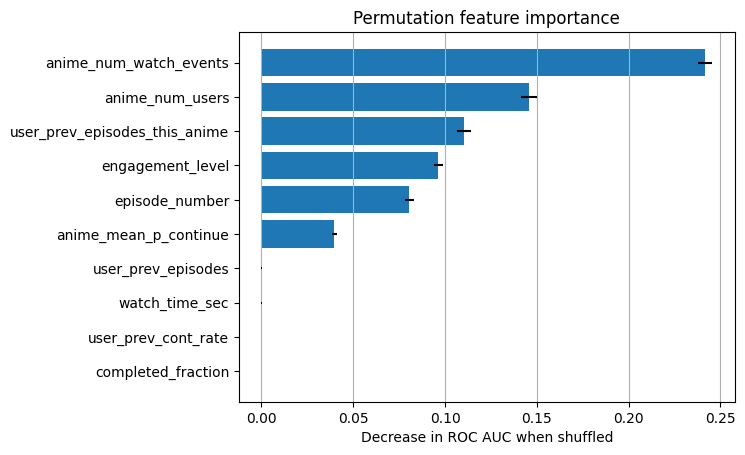

In [22]:
plt.figure()
plt.barh(
    fi_df["feature"],
    fi_df["importance_mean"],
    xerr=fi_df["importance_std"],
)
plt.gca().invert_yaxis()
plt.xlabel("Decrease in ROC AUC when shuffled")
plt.title("Permutation feature importance")
plt.grid(axis="x")
plt.show()

## Performance by episode number

We can check whether the model behaves differently on:

- Early episodes (1–3)
- Mid season (4–8)
- Later episodes (9+)

For simplicity, we:

- Attach episode_number back from the dataframe
- Compute accuracy and ROC AUC per episode bucket

In [23]:
# Attach episode number and predictions back to a frame
val_df = ml_df.iloc[y_train.shape[0]:].copy().reset_index(drop=True)

In [24]:
# Sanity check shapes
print("Length of val_df:", len(val_df))
print("Length of y_val:", len(y_val))
print("Length of y_proba:", len(y_proba))

Length of val_df: 10141
Length of y_val: 10141
Length of y_proba: 10141


In [25]:
# Create buckets
def bucket_ep(ep):
    if ep <= 3:
        return "1-3"
    elif ep <= 8:
        return "4-8"
    else:
        return "9+"

In [26]:
val_df["episode_bucket"] = val_df["episode_number"].apply(bucket_ep)
val_df["y_true"] = y_val
val_df["y_proba"] = y_proba
val_df["y_pred"] = (val_df["y_proba"] >= 0.5).astype(int)

In [27]:
bucket_stats = []
for bucket, grp in val_df.groupby("episode_bucket"):
    if grp["y_true"].nunique() < 2:
        # ROC AUC not defined if only one class present
        auc = np.nan
    else:
        auc = roc_auc_score(grp["y_true"], grp["y_proba"])
    acc = accuracy_score(grp["y_true"], grp["y_pred"])
    bucket_stats.append(
        {
            "episode_bucket": bucket,
            "n_rows": len(grp),
            "accuracy": acc,
            "roc_auc": auc,
        }
    )
bucket_stats_df = pd.DataFrame(bucket_stats).sort_values("episode_bucket")
bucket_stats_df

,episode_bucket,n_rows,accuracy,roc_auc
0,1-3,6985,0.817037,0.859398
1,4-8,3001,0.818394,0.858318
2,9+,155,0.754839,0.852632


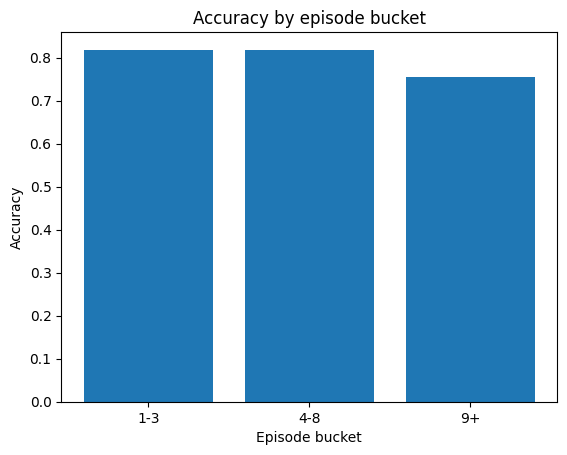

In [28]:
plt.figure()
plt.bar(bucket_stats_df["episode_bucket"], bucket_stats_df["accuracy"])
plt.xlabel("Episode bucket")
plt.ylabel("Accuracy")
plt.title("Accuracy by episode bucket")
plt.show()

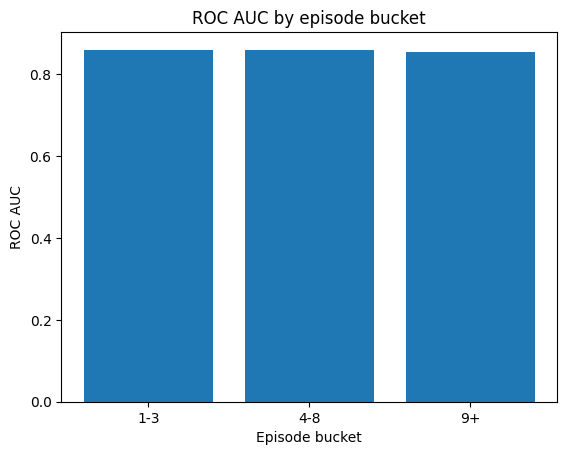

In [29]:
plt.figure()
plt.bar(bucket_stats_df["episode_bucket"], bucket_stats_df["roc_auc"])
plt.xlabel("Episode bucket")
plt.ylabel("ROC AUC")
plt.title("ROC AUC by episode bucket")
plt.show()

## Summary

In this notebook we:

- Loaded the ML dataset and trained model
- Recomputed and visualised:
  - ROC curve
  - Precision and recall vs threshold
  - Confusion matrix at default 0.5 cut
- Used permutation importance to see which features matter most
- Looked at how performance varies with episode number

This completes the synthetic modeling loop:
metadata → synthetic logs → features → model → analysis.